# Generate yellow smiley faces 🙂

## load dependencies
* matplotlib for plotting
* numpy for array handling
* json for loading emoji description
* mpimg and glob for reading PNG
* tensorflow for GAN

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import json
import glob
import random
from pprint import pprint

## filter and load emoji files

In [2]:
# filter only person emojis without tones
with open('emoji-data/emoji.json') as data_file:
    emojis = json.load(data_file)

#smileys = [e for e in emojis if e["category"] != "Symbols" and e["category"] != "Flags" and e["category"] != "Regional"]
smileys = [e for e in emojis if e["category"] == "People"]


pprint("minimized dictionary: {} left out of {} emojis".format(len(smileys), len(emojis)))
pprint(smileys[3])

'minimized dictionary: 314 left out of 1489 emojis'
{'added_in': '1.1',
 'au': None,
 'category': 'People',
 'docomo': None,
 'google': None,
 'has_img_apple': True,
 'has_img_emojione': True,
 'has_img_facebook': True,
 'has_img_google': True,
 'has_img_messenger': False,
 'has_img_twitter': True,
 'image': '2639.png',
 'name': 'WHITE FROWNING FACE',
 'sheet_x': 1,
 'sheet_y': 16,
 'short_name': 'white_frowning_face',
 'short_names': ['white_frowning_face'],
 'softbank': None,
 'sort_order': 38,
 'text': None,
 'texts': None,
 'unified': '2639',
 'variations': ['2639-FE0F']}


In [3]:
# filter all files for the given smiley unicodes
paths = [
    "emoji-data/img-apple-64",
    "emoji-data/img-emojione-64",
    "emoji-data/img-facebook-64",
    "emoji-data/img-google-64",
    "emoji-data/img-messenger-64",
    "emoji-data/img-twitter-64"
]
filenames = [s["image"] for s in smileys]
filepaths = []
for p in paths:
    image_paths = glob.glob(p + "/*.png")
    filtered = [p for p in image_paths if p.split("/")[-1] in filenames]
    filepaths = filepaths + filtered

In [4]:
def is_emoji(img):
    yellowishness = np.sum(np.logical_and(np.logical_and(img[:, :, 0] > 0.6, np.logical_and(img[:, :, 1] > 0.6, img[:, :, 3] > 0.8)), img[:, :, 2] < 0.6)) / np.sum(img[:, :, 2] < 0.6) 
    transparencyness = np.sum(img[:, :, 3] > 0.8) / (64 * 64)
    return yellowishness > 0.5 and transparencyness > 0.7

In [5]:
# strip transparency dimension (because RGB channels are crazy in transparencent spaces)
def strip_transparency(i):
    px_transparent = i[:, :, 3] < 0.1
    i[px_transparent, 0:3] = 1
    i = i[:, :, 0:3]
    return i

In [6]:
# load all files
images = [mpimg.imread(f) for f in filepaths]
images = [i for i in images if i.shape == (64, 64, 4)]
images = [i for i in images if is_emoji(i)]
images = [strip_transparency(i) for i in images]

pprint(len(images))

273


y: 0.8809082483781279
y: 0.9051204819277109
y: 0.754996776273372
y: 0.9006269592476489


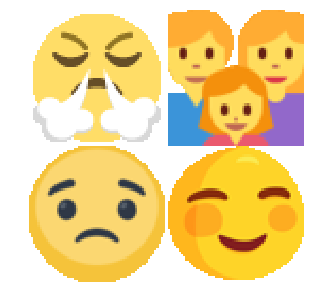

In [7]:
# display random emojis
column_count = 2 # emojis per column
display_count = column_count**2 # total number of emojis to show (aligns neatly if it's a square)

f, axarr = plt.subplots(display_count//column_count, column_count, sharex=True, sharey=True, figsize=(5,5))
for (i, img) in enumerate(random.sample(images, display_count)):
    a = axarr[i%(display_count//column_count), i//(display_count//column_count)]
    yellowishness = np.sum(np.logical_and(np.logical_and(img[:, :, 0] > 0.6, img[:, :, 1] > 0.6), img[:, :, 2] < 0.6)) / np.sum(img[:, :, 2] < 0.6) 
    print("y: {}".format(yellowishness))
    a.axis("off")
    a.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

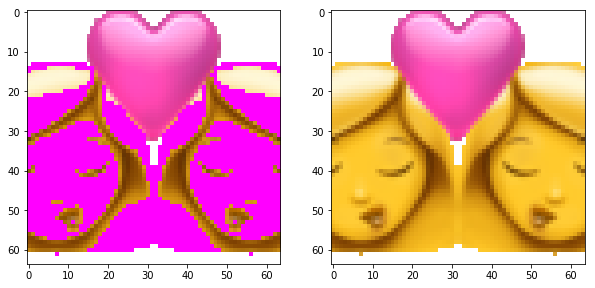

In [8]:
# figuring out how to filter for round yellow emojis..
i = images[0]
yellow_pixels = np.logical_and(i[:, :, 0] > 0.7, img[:, :, 1] > 0.7)
f, axarr = plt.subplots(1, 2, figsize=(10,10))

o = np.copy(i)
pixls = np.logical_and(np.logical_and(o[:, :, 0] > 0.6, o[:, :, 1] > 0.6), o[:, :, 2] < 0.6)
o[pixls] = [1, 0, 1]
axarr[0].imshow(o)
axarr[1].imshow(i)

## emojis

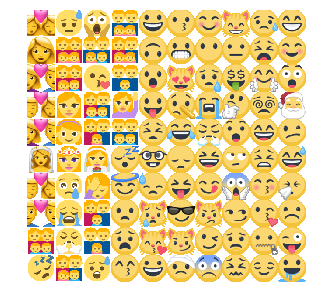

In [9]:
# plot emojis in order
lines = 10
f, axarr = plt.subplots(lines, lines, sharex=True, sharey=True, figsize=(5,5))
for i in range(lines**2):
    a = axarr[i%(lines), i//(lines)]
    img = images[i]
    a.axis("off")
    a.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

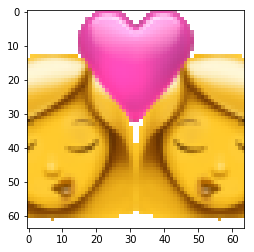

In [10]:
# only select one emoji for training
#images = [images[99]]
plt.imshow(images[0])

## preprocessing functions

In [11]:
scale_min_val=-1
scale_max_val=1
def scale(x):

    # scale to feature_range
    x = x * (scale_max_val - scale_min_val) + scale_min_val
    return x

def unscale(x):
    # scale to (0, 1)
   
    x = (x - scale_min_val) / (scale_max_val - scale_min_val)
    return x

In [12]:
def get_batches(images, batch_size, shuffle=True):
    images = np.array(images)
    if shuffle:
        idx = np.arange(len(images))
        np.random.shuffle(idx)
        images = images[idx]
    n_batches = len(images)//batch_size
    for i in range(0, len(images), batch_size):
        x = images[i:i+batch_size]
        yield x

In [13]:
i = scale(images[0])
print(i.shape)
print(np.max(i), np.min(i))

(64, 64, 3)
1.0 -1.0


## define network


In [14]:
# inputs
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [15]:
def generator(z, output_dim, reuse=False, alpha=0.2, is_train=True):
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=8*8*1024, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 8, 8, 1024))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=is_train)
        conv1 = tf.nn.relu(conv1)
        # > 8*8
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=is_train)
        conv2 = tf.nn.relu(conv2)
        # > 16*16
        
        conv3 = tf.layers.conv2d_transpose(inputs=conv2, filters=256, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=is_train)
        conv3 = tf.nn.relu(conv3)
        # > 32*32
        
        # Output layer, 64*64
        logits = tf.layers.conv2d_transpose(inputs=conv3, filters=output_dim, kernel_size=5, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
    
    return out

In [16]:
def discriminator(x, reuse=False, alpha=0.01):

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 64*64
        conv1 = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.nn.relu(conv1)
        # > 32*32
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=256, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.nn.relu(conv2)
        # > 16*16

        conv3 = tf.layers.conv2d(inputs=conv2, filters=1024, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        conv3 = tf.nn.relu(conv3)
        # > 8*8
        
        flat = tf.reshape(conv3, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flat, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [17]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smooth_factor = 0.1 # reduce true "correct" by this factor
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [18]:
def model_opt(d_loss, g_loss, learning_rate_d, learning_rate_g, beta1, beta2):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate_d, beta1=beta1, beta2=beta2).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate_g, beta1=beta1, beta2=beta2).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [19]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate_d, learning_rate_g, alpha=0.2, beta1=0.5, beta2=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate_d, learning_rate_g, beta1, beta2)

In [20]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = (unscale(img)).astype(np.uint8)
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [21]:
def train(net, images, epochs, batch_size, print_every=10, show_every=30, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(images, batch_size):
                steps += 1
                x = [scale(i) for i in x]

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                #_ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, is_train=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [22]:
# hyper params
real_size = (64,64,3)
z_size = 128
learning_rate_d = 0.0003
learning_rate_g = 0.0003
batch_size = 32
epochs = 1000
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate_d, learning_rate_g, beta1=beta1)

Epoch 4/1000... Discriminator Loss: 2.8431... Generator Loss: 11.6085
Epoch 7/1000... Discriminator Loss: 3.5325... Generator Loss: 7.0420
Epoch 10/1000... Discriminator Loss: 0.6035... Generator Loss: 3.3332


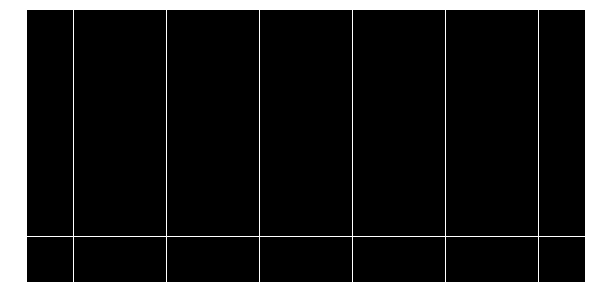

Epoch 14/1000... Discriminator Loss: 7.0535... Generator Loss: 0.0117
Epoch 17/1000... Discriminator Loss: 0.7569... Generator Loss: 2.2439
Epoch 20/1000... Discriminator Loss: 1.5479... Generator Loss: 0.7368


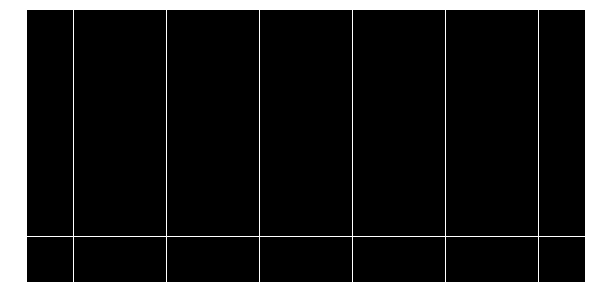

Epoch 24/1000... Discriminator Loss: 0.5878... Generator Loss: 5.4448
Epoch 27/1000... Discriminator Loss: 0.8322... Generator Loss: 1.9799
Epoch 30/1000... Discriminator Loss: 0.8872... Generator Loss: 5.3272
Epoch 34/1000... Discriminator Loss: 1.8115... Generator Loss: 0.6553


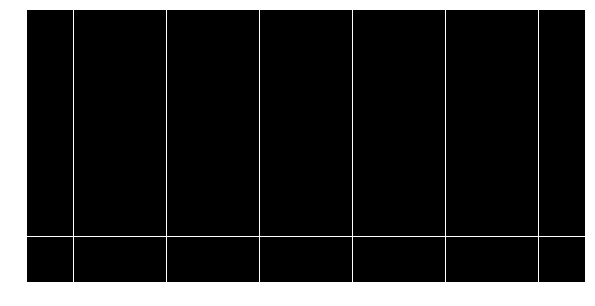

Epoch 37/1000... Discriminator Loss: 0.8069... Generator Loss: 5.7676
Epoch 40/1000... Discriminator Loss: 0.5570... Generator Loss: 4.9206
Epoch 44/1000... Discriminator Loss: 0.8436... Generator Loss: 1.9000


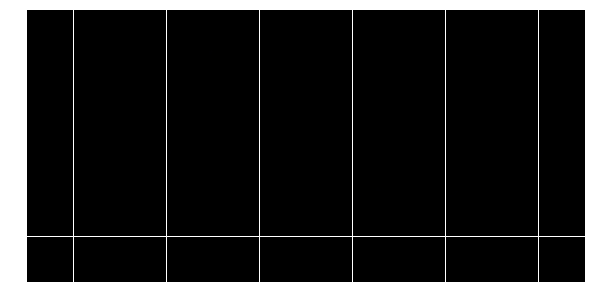

KeyboardInterrupt: 

In [23]:
# Load the data and train the network here
losses, samples = train(net, images, epochs, batch_size, print_every=30, show_every=100, figsize=(10,5))

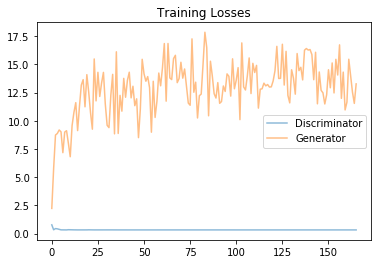

In [83]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

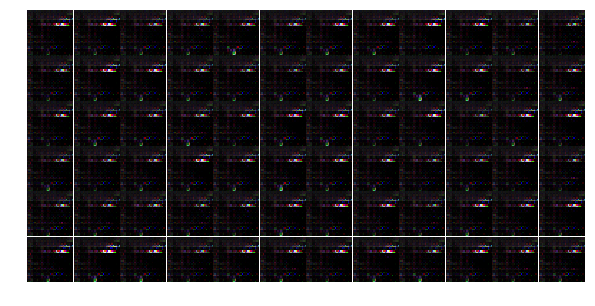

In [82]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))